# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом по классификации emoji из тг. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 100 классов и около 100 картинок на каждый класс. Классы пронумерованы, кодом смайлика к которому относятся элементы класса. Скачать датасет можно вот [тут](https://disk.yandex.ru/d/elNF0DS94o2GVA).

Структура датасета -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.24**. В этом задании :**запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.34**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.4)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.4) / 0.4)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе.

Good luck & have fun! :)

Так ну в кратце я учил локально на серевер gpudc, поэтому выкинул всё с гугл диском. Просто для сложных моделек типа resnet50 c ресайзом переимущество V100 против T4 8 итераций в сек против 0.25... Значительная разница за 25 то рублей в час. Вотьььь

In [ ]:
#!pip install wandb

In [3]:
import wandb

In [4]:
from wandb_key import API_KEY # Б - безопастность

wandb.login(key=API_KEY)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dima-malinitskiy (dima-malinitskiy-hse-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


True

In [ ]:
#!pip install pytorch_lightning

In [ ]:
#!pip install torch

In [ ]:
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать свою модель руками в классе YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:

# import zipfile


# os.makedirs('/content/drive/MyDrive/Colab Notebooks/dataset_IAD_OMO_2/train', exist_ok=True)
# os.makedirs('/content/drive/MyDrive/Colab Notebooks/dataset_IAD_OMO_2/val', exist_ok=True)
# train_zip_path = '/content/drive/MyDrive/Colab Notebooks/dataset_IAD_OMO_2/train.zip'
# val_zip_path = '/content/drive/MyDrive/Colab Notebooks/dataset_IAD_OMO_2/val.zip'

# with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/dataset_IAD_OMO_2')

# with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/dataset_IAD_OMO_2')   

# До того как пересел на провославный сервер, где на норм проце через unzip train.zip распаковывалось за 4 секунды, против колабоских 4 минут, я всё больше не люблю колаб.

In [ ]:
train_transform = transforms.ToTensor()
val_transform = transforms.ToTensor()

train_dataset = ImageFolder('/home/user/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/home/user/dataset/val', transform=val_transform)


# from torch.utils.data import Subset    # Можно брать данные кусочками, чтобы бстро прогонять модельки для оценики, ну так постетил, но понял что фигня
# import numpy as np

# # Фиксируем seed для воспроизводимости
# seed = 42
# np.random.seed(seed)

# # Перемешиваем индексы
# train_indices = np.random.permutation(len(train_dataset))[:18000]
# val_indices = np.random.permutation(len(val_dataset))[:1000]

# # Создаем подмножества
# train_dataset = Subset(train_dataset, train_indices)
# val_dataset = Subset(val_dataset, val_indices)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)



In [11]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

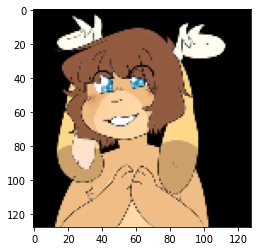

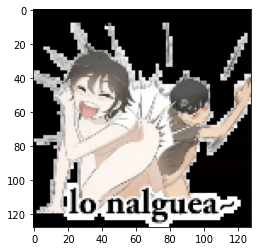

In [12]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[6].permute(1, 2, 0))
    plt.show()
    break

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.24. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
# class YourNet(nn.Module):
#     def __init__(self):
#         super(YourNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(128)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.3333)
#         self.fc1 = nn.Linear(128 * 8 * 8, 256)
#         self.fc2 = nn.Linear(256, 100)

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))  
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))  
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))  
#         x = self.pool(F.relu(self.bn4(self.conv4(x))))  
#         x = x.view(x.size(0), -1)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.fc2(x)
#         return x       #тут много всякого было, моделек 40 полегло, игрался с параметрами, но понял что готовые лучше... 

# from torchvision.models import resnet18

# class YourNet(nn.Module):
#     def __init__(self, num_classes=100):      # 9 эпох бач 32 0.2292 другие бачи ужас
#         super(YourNet, self).__init__()       # https://habr.com/ru/articles/830836/
#         self.resnet = resnet18(weights=None)  # Без предобученных весов!!!!!
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.resnet(x)

# from torchvision.models import resnet34

# class YourNet(nn.Module):
#     def __init__(self, num_classes=100):
#         super(YourNet, self).__init__()       #чуть хуже чем 18, 2252 10 эпох батч 32
#         self.resnet = resnet34(weights=None)  # Без предобученных весов
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.resnet(x)

from torchvision.models import densenet121

class YourNet(nn.Module):
    def __init__(self, num_classes=100):
        super(YourNet, self).__init__()
        self.densenet = densenet121(weights=None)  # Без предобученных весов!!!!!!
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)




### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super(YourModule, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x, y = x.to(self.device), y.to(self.device)
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = accuracy(preds.softmax(dim=-1), y, task="multiclass", num_classes=100)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        x, y = x.to(self.device), y.to(self.device)
        preds = self(x)
        loss = self.criterion(preds, y)
        acc = accuracy(preds.softmax(dim=-1), y, task="multiclass", num_classes=100)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

In [19]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
model = YourNet()
module = YourModule(model)

trainer = pl.Trainer(logger=wandb_logger, accelerator='gpu', max_epochs=30)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | YourNet          | 7.1 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.225    Total estimated model params size (MB)
435       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### Валидация результатов задания

In [21]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            preds = model(images)
            acc_batch = (preds.argmax(dim=1) == labels).float().mean().item()
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

accuracy = evaluate_task(module, val_dataloader)
print(accuracy)
print(f"Оценка за это задание составит {np.clip(5 * accuracy / 0.24, 0, 5):.2f} баллов")


  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:02<00:00, 35.90it/s]

0.2298259493670886
Оценка за это задание составит 4.79 баллов


Там в моменте было чуть лучше (0.2356 по wand можно посмотреть), но мне лень туда откатываться, и переобучать ещё 40 минут, а это при аренде сервера 15 рублей в час, 10 рублей так то, речь идет о крупных деньгах)))

In [ ]:
torch.save(model.state_dict(), 'densenet121.pth')
# веса лежат тут, если интересно https://disk.yandex.ru/d/1mvUlkrTVnQOEw

## Задание 2 
# Во втором файле ПРОДОЛЖЕНИЕ это не конец!!!!

# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Ну что тут написать, начну с мема

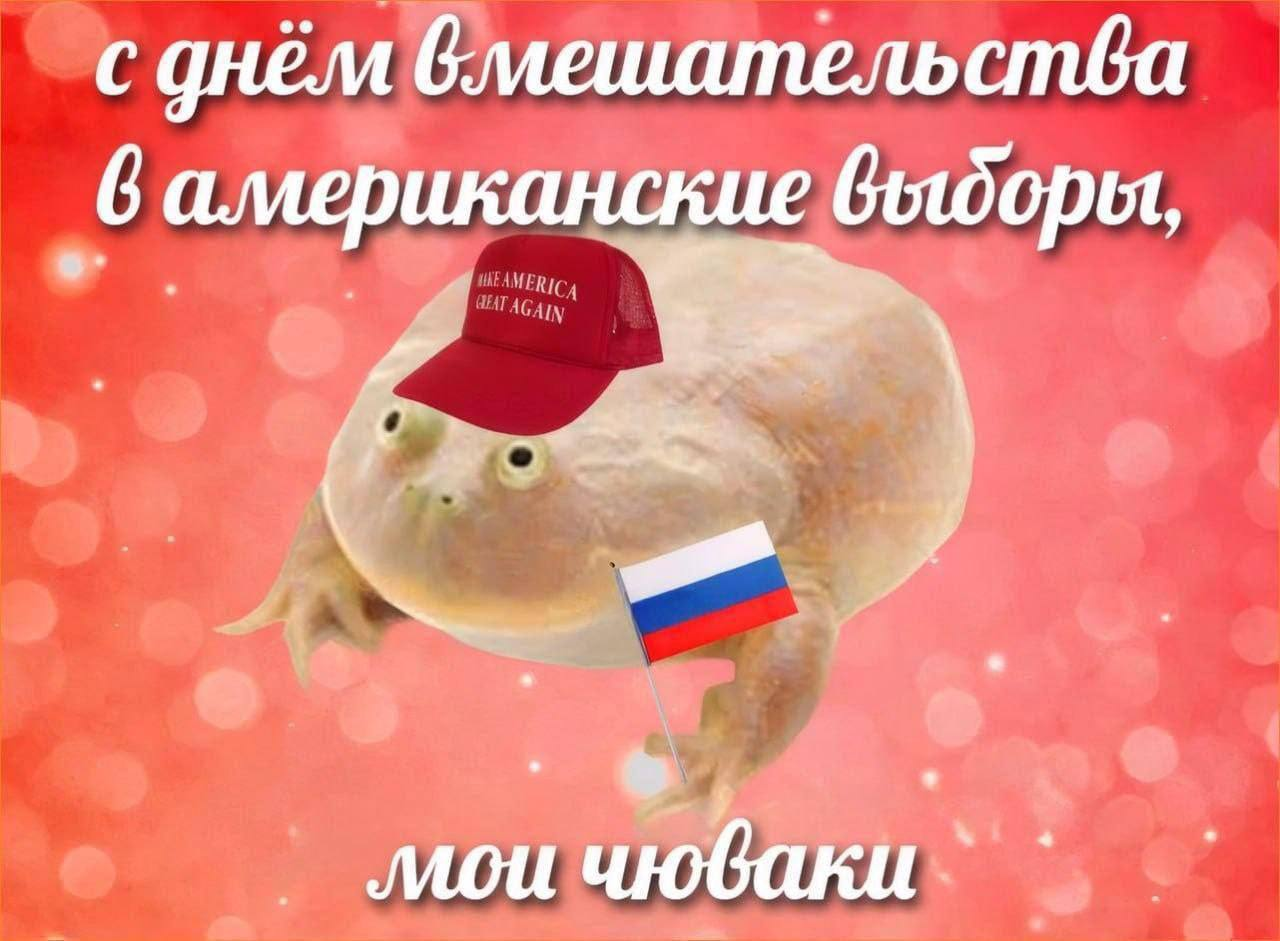

Ну а по модельке, вот ссылка на трекер, веселился я долго, первых 40 эпох я подбирал свою модель, потом плюнул, начал юзать другие

https://api.wandb.ai/links/dima-malinitskiy-hse-university/uqnmu11c